# stata

> Simple wrappers for `pystata`/`sfi` functionality
- order: 2

`sfi` is [Stata's python API](https://www.stata.com/python/api17/index.html), originally intended for interacting with Stata from python *within Stata*. As such, it can only be imported with Stata running.
`pystata.stata.run` [enables running Stata code from python](https://www.stata.com/python/pystata18/stata.html#pystata.stata.run).

For one thing, using wrappers removes the need to constantly import `pystata` and/or `sfi` within functions elsewhere to avoid running afoul of CI tests in an environment without Stata installed.

In [ ]:
#| default_exp stata
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from nbstata.misc_utils import print_red
from contextlib import redirect_stdout
from io import StringIO

In [ ]:
#| hide
from nbstata.config import launch_stata
from nbstata.misc_utils import Timer
from textwrap import dedent
from fastcore.test import test_eq, ExceptionExpected

In [ ]:
#| hide
#| eval: False
launch_stata(splash=False)

## Simple wrappers

In [ ]:
#| export
def get_local(name):
    import sfi
    return sfi.Macro.getLocal(name)

[https://www.stata.com/python/api17/Macro.html#sfi.Macro.getLocal](https://www.stata.com/python/api17/Macro.html#sfi.Macro.getLocal)

In [ ]:
#| export
def set_local(name, value):
    import sfi
    return sfi.Macro.setLocal(name, value)

[https://www.stata.com/python/api17/Macro.html#sfi.Macro.getGlobal](https://www.stata.com/python/api17/Macro.html#sfi.Macro.getGlobal)

In [ ]:
#| export
def get_global(name):
    import sfi
    return sfi.Macro.getGlobal(name)

[https://www.stata.com/python/api17/Macro.html#sfi.Macro.setGlobal](https://www.stata.com/python/api17/Macro.html#sfi.Macro.setGlobal)

In [ ]:
#| export
def set_global(name):
    import sfi
    return sfi.Macro.setGlobal(name, value)

[https://www.stata.com/python/api17/Macro.html#sfi.Macro.getGlobal](https://www.stata.com/python/api17/Macro.html#sfi.Macro.getGlobal)

In [ ]:
#| export
def get_scalar(name):
    import sfi
    return sfi.Scalar.getValue(name)

[https://www.stata.com/python/api17/Scalar.html?highlight=scalar#sfi.Scalar.getValue](https://www.stata.com/python/api17/Scalar.html?highlight=scalar#sfi.Scalar.getValue)

In [ ]:
#| export
def stata_formatted(value, s_format):
    import sfi
    return sfi.SFIToolkit.formatValue(value, s_format)

[https://www.stata.com/python/api17/SFIToolkit.html#sfi.SFIToolkit.formatValue](https://www.stata.com/python/api17/SFIToolkit.html#sfi.SFIToolkit.formatValue)

In [ ]:
#| export
def variable_names():
    from sfi import Data
    return [Data.getVarName(i) for i in range(Data.getVarCount())]

`variable_names` uses 'getVarCount' and 'getVarName': [https://www.stata.com/python/api17/Data.html](https://www.stata.com/python/api17/Data.html)

In [ ]:
#| hide
#| eval: False
import sfi

In [ ]:
#| eval: false
sfi.SFIToolkit.stata("quietly gen var1 = 1")
variable_names()

['var1']

In [ ]:
#| export
def drop_var(name):
    import sfi
    sfi.Data.dropVar(name)

[https://www.stata.com/python/api17/Data.html#sfi.Data.dropVar](https://www.stata.com/python/api17/Data.html#sfi.Data.dropVar)

In [ ]:
#| eval: False
drop_var('var1')
variable_names()

[]

In [ ]:
#| export
def obs_count():
    """Count the number of observations"""
    import sfi
    return sfi.Data.getObsTotal()

[https://www.stata.com/python/api17/Data.html#sfi.Data.getObsTotal](https://www.stata.com/python/api17/Data.html#sfi.Data.getObsTotal)

In [ ]:
#| eval: false
obs_count()

0

In [ ]:
#| export
def pwd():
    from sfi import SFIToolkit
    return SFIToolkit.getWorkingDir()

[https://www.stata.com/python/api17/SFIToolkit.html#sfi.SFIToolkit.getWorkingDir](https://www.stata.com/python/api17/SFIToolkit.html#sfi.SFIToolkit.getWorkingDir)

In [ ]:
#| eval: False
pwd()[-12:]

'\\nbstata\\nbs'

In [ ]:
#| export
def macro_expand(s):
    from sfi import SFIToolkit
    return SFIToolkit.macroExpand(s)

[https://www.stata.com/python/api17/SFIToolkit.html#sfi.SFIToolkit.macroExpand](https://www.stata.com/python/api17/SFIToolkit.html#sfi.SFIToolkit.macroExpand)

## Running arbitrary Stata code

In [ ]:
#| export
def run_direct(cmds, quietly=False, echo=False, inline=True):
    import pystata
    return pystata.stata.run(cmds, quietly, echo, inline)

`run_direct` wraps the most flexible utility Stata provides to run Stata commands: [pystata.stata.run](https://www.stata.com/python/pystata18/stata.html#pystata.stata.run)

In [ ]:
#| eval: False
run_direct("""\
disp 1
disp 2""", echo=True)


. disp 1
1

. disp 2
2

. 


#| hide
- Note that multi-line Stata code is always echoed by `pystata.stata.run`:

In [ ]:
#| hide
#| eval: False
run_direct("""\
quietly {
    disp 2
}""", echo=False)


. quietly {

. 


In [ ]:
#| hide
#| eval: False
run_direct(dedent('''\
    python:
    print("hello")
    end
    '''), echo=False)


. python:
----------------------------------------------- python (type end to exit) -----
>>> print("hello")
hello
>>> end
-------------------------------------------------------------------------------

. 


In [ ]:
#| hide
#| eval: False
code = dedent('''\
    python:
    print("hello")
    end
    ''')
run_direct(code, quietly=True)

hello



In [ ]:
#| hide
#| eval: False
code = dedent('''\
    python:
    do_nothin = 3
    end
    ''')
run_direct(code, quietly=True)

In [ ]:
#| export
def run_single(cmd, echo=False):
    import sfi
    try:
        sfi.SFIToolkit.stata(cmd, echo)
    except Exception as e:
        with redirect_stdout(StringIO()) as diverted:
            sfi.SFIToolkit.stata("", echo)
        raise SyntaxError(diverted.getvalue())

`run_single` uses an `sfi` function for running a single command that is notably faster than `pystata.stata.run` but is less versatile and appears less resilient to errors: [https://www.stata.com/python/api17/SFIToolkit.html#sfi.SFIToolkit.stata](https://www.stata.com/python/api17/SFIToolkit.html#sfi.SFIToolkit.stata)

In [ ]:
#| eval: False
import sfi, pystata

In [ ]:
#| eval: False
with Timer():
    sfi.SFIToolkit.stata("disp 0")
with Timer():
    pystata.stata.run("disp 0")

0
Elapsed time: 0.0001 seconds
0
Elapsed time: 0.0484 seconds


For example, it cannot display graphs, silently quashing them instead:

In [ ]:
#| eval: False
sfi.SFIToolkit.stata("sysuse lifeexp, clear")
sfi.SFIToolkit.stata("scatter gnppc lexp")

(Life expectancy, 1998)


. scatter gnppc lexp


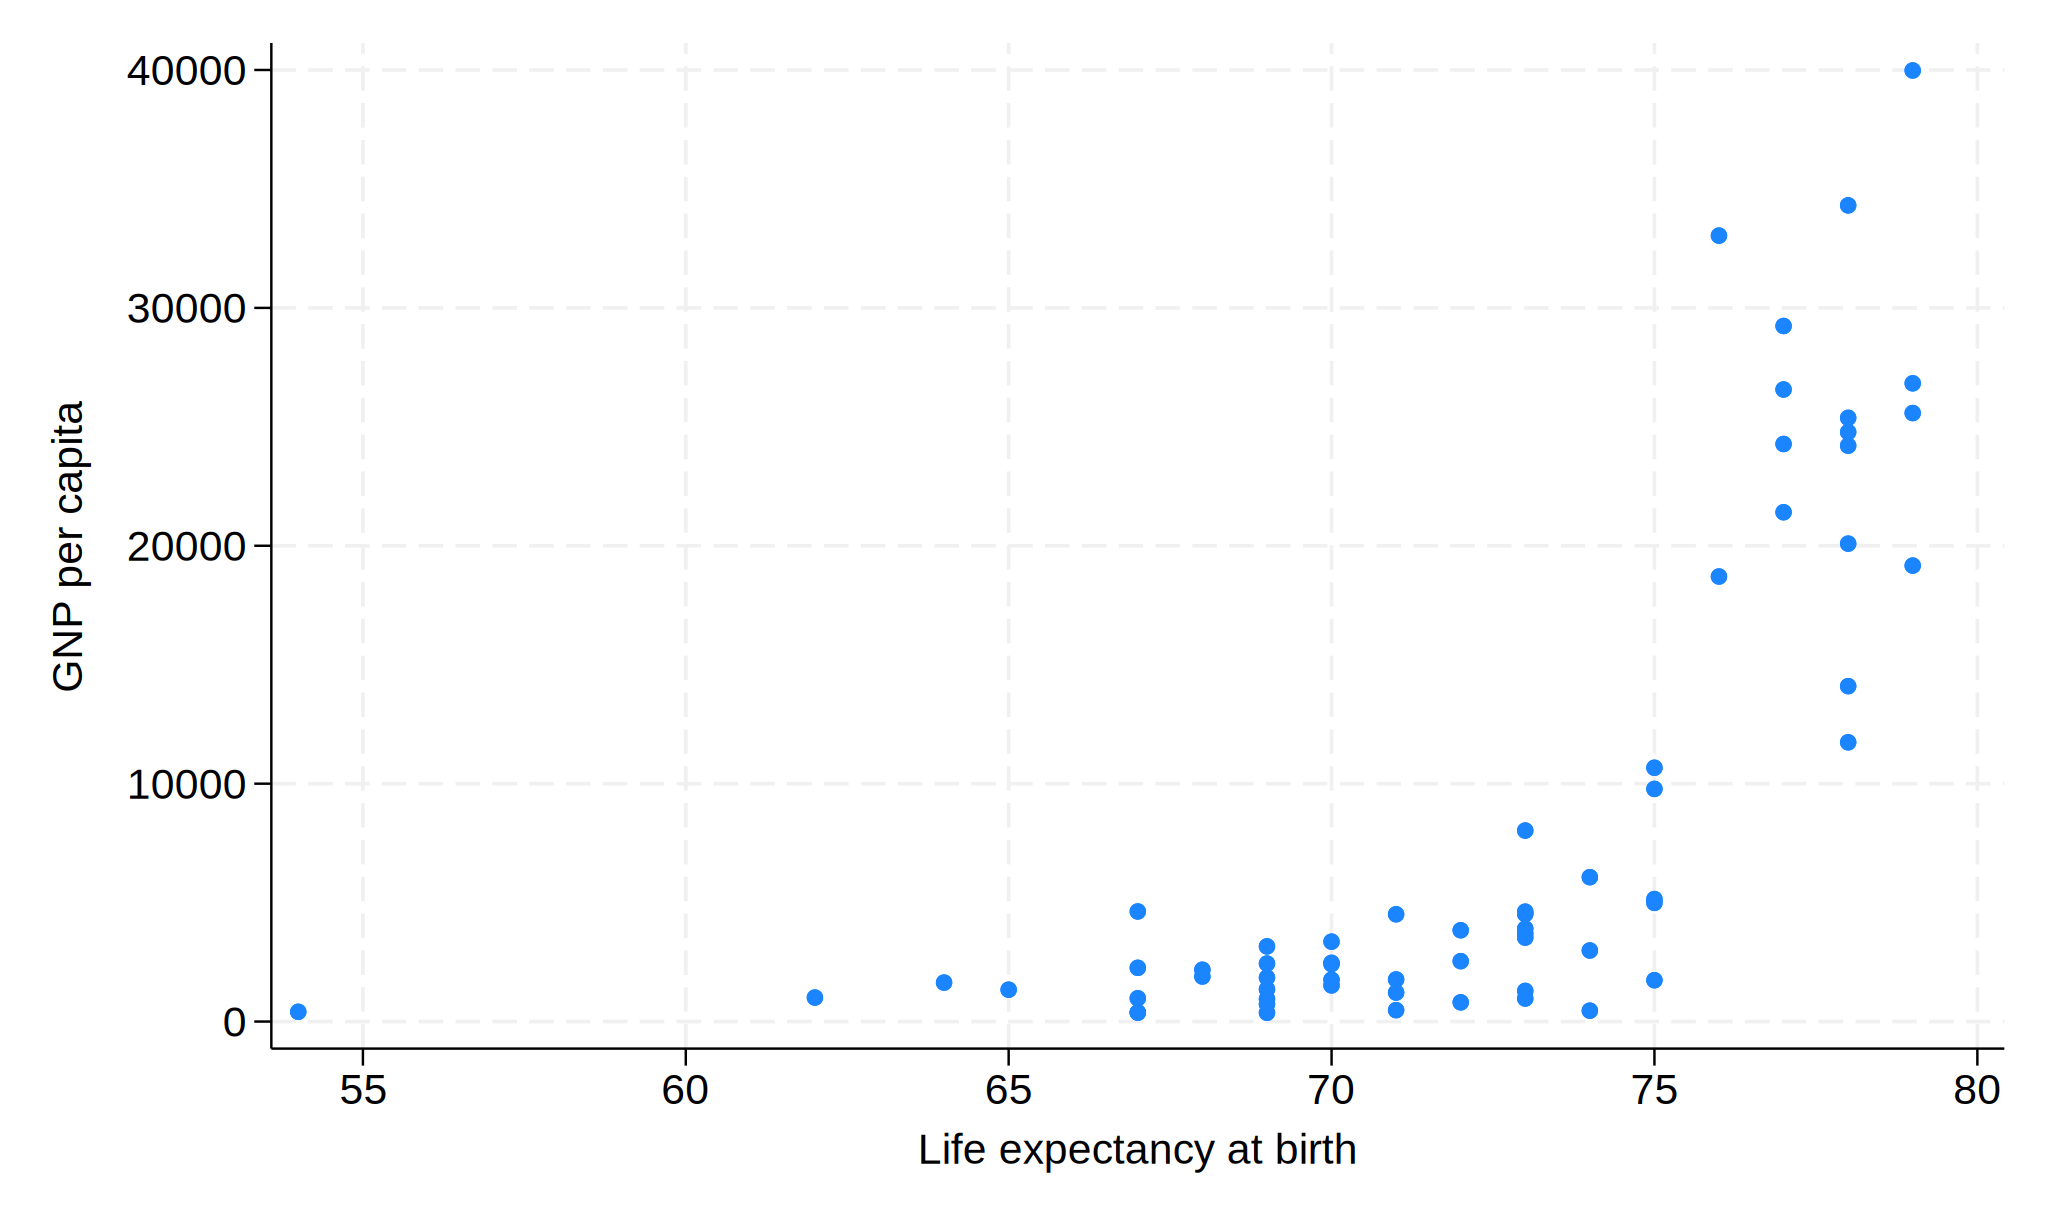

In [ ]:
#| eval: False
run_direct("scatter gnppc lexp", echo=True)

In [ ]:
#| hide
#| eval: False
sfi.SFIToolkit.stata("clear")

Even worse, a subsequent run of `sfi.SFIToolkit.stata` can be affected by a previous error:

In [ ]:
#| eval: False
try:
    sfi.SFIToolkit.stata("disp 1 \n disp 2")
except Exception as e:
    print(repr(e))

SyntaxError('failed to execute the specified Stata command')


In [ ]:
#| eval: False
sfi.SFIToolkit.stata('disp "1b"')

1
 invalid name
1b


But an intervening blank run seems to set things right:

In [ ]:
#| eval: False
try:
    sfi.SFIToolkit.stata("disp 1 \n disp 2")
except Exception:
    sfi.SFIToolkit.stata("")

1
 invalid name


In [ ]:
#| eval: False
sfi.SFIToolkit.stata('disp "1b"')

1b


So `run_single` should only be used with care. For when it is used, in case of error-causing input code, it executes `sfi.SFIToolkit.stata` again (with stdout redirected) to prevent the effects of the error from persisting.

In [ ]:
#| eval: False
with ExceptionExpected(ex=SyntaxError):
    run_single("disp 1 \n disp 2")

In [ ]:
#| eval: false
run_single('disp "1b"')

1b


In [ ]:
#| hide
#| eval: false
with ExceptionExpected(ex=SyntaxError):
    run_single("invalid_Stata_command")

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()